# Sentiment in FOMC statements

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import date
from tqdm.auto import tqdm
from pathlib import Path

from matplotlib import pyplot as plt

from skfin.plot import bar, line

## Sentiment in FOMC statements: Loughran-McDonalds dictionary

In this section, we measure sentiment with the Loughran-McDonalds sentiment dictionary in two ways: 

- sentiment = (#positive - #negative)/(#positive + #negative)
- sentiment = (#positive - #negative)/(#words)

In the first case, short documents (with few or no sentiment words) might lead to biased estimates. 

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from skfin.datasets import load_fomc_statements, load_loughran_mcdonald_dictionary
from skfin.text import coefs_plot
from skfin.text import show_text
from skfin.plot import line

In [3]:
statements = load_fomc_statements()
lm = load_loughran_mcdonald_dictionary()

INFO:skfin.datasets:logging from cache file: /home/schamponn/dev/projects/skfin/nbs/data/fomc_statements.parquet
INFO:skfin.datasets:logging from cache file: /home/schamponn/dev/projects/skfin/nbs/data/Loughran-McDonald_MasterDictionary_1993-2021.csv


In [4]:
X = statements['text']

In [5]:
funcs = {'negative': lambda x: x.Negative>0, 'positive': lambda x: x.Positive>0,
         'all': lambda x: x.Word.notna()}
def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()},
                          axis=1)

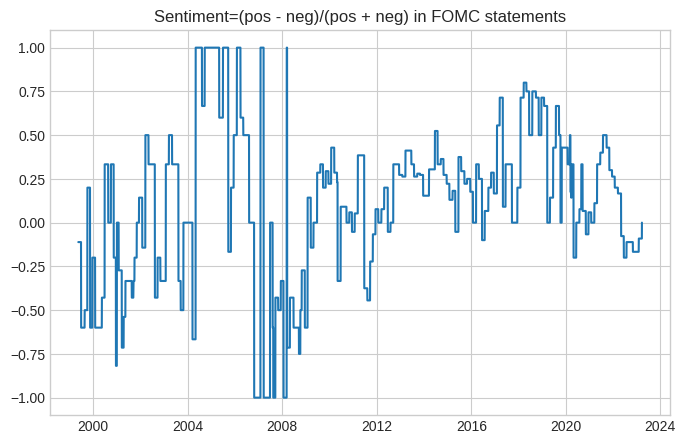

In [6]:
line(lm_counts.pipe(lambda x:(x.positive-x.negative)/(x.positive + x.negative)).resample('B').last().ffill(),
legend=False, title='Sentiment=(pos - neg)/(pos + neg) in FOMC statements')

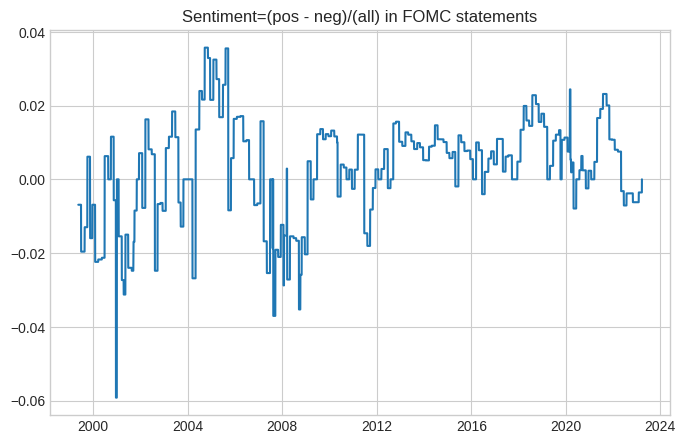

In [7]:
line(lm_counts.pipe(lambda x:(x.positive-x.negative)/x['all']).resample('B').last().ffill(),
legend=False, title='Sentiment=(pos - neg)/(all) in FOMC statements')

In [8]:
lm_lexica = {'negative': pd.Series(1, lm.loc[lm.Negative>0].Word.str.lower().values),
'positive': pd.Series(1, lm.loc[lm.Positive>0].Word.str.lower().values)}
show_text(statements.loc[['2000-12-19', '2013-12-18', '2014-01-29']],
lexica=lm_lexica, n=None)

## Sentiment in FOMC statements: supervised learning

Building on previous analyses, we build here a `scikit-learn pipeline` with a `Tfidfvectorizer` and a regularized regression`ElasticNet`. The target is the return of the market on the day of the statement. 

In [9]:
import numpy as np
from skfin.datasets import load_kf_returns
from skfin.text import show_text
from pandas.tseries.offsets import BDay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [10]:
ret = load_kf_returns(filename="F-F_Research_Data_Factors_daily")['Daily']

INFO:skfin.datasets:logging from cache directory: /home/schamponn/dev/projects/skfin/nbs/data/F-F_Research_Data_Factors_daily


In [11]:
special_days = ['2008-01-22', '2010-05-09', '2020-03-15']
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0).union(idx0 + BDay(1))
ret_fomc = ret.div(ret.ewm(252).std()).loc[ret.index.intersection(idx)]

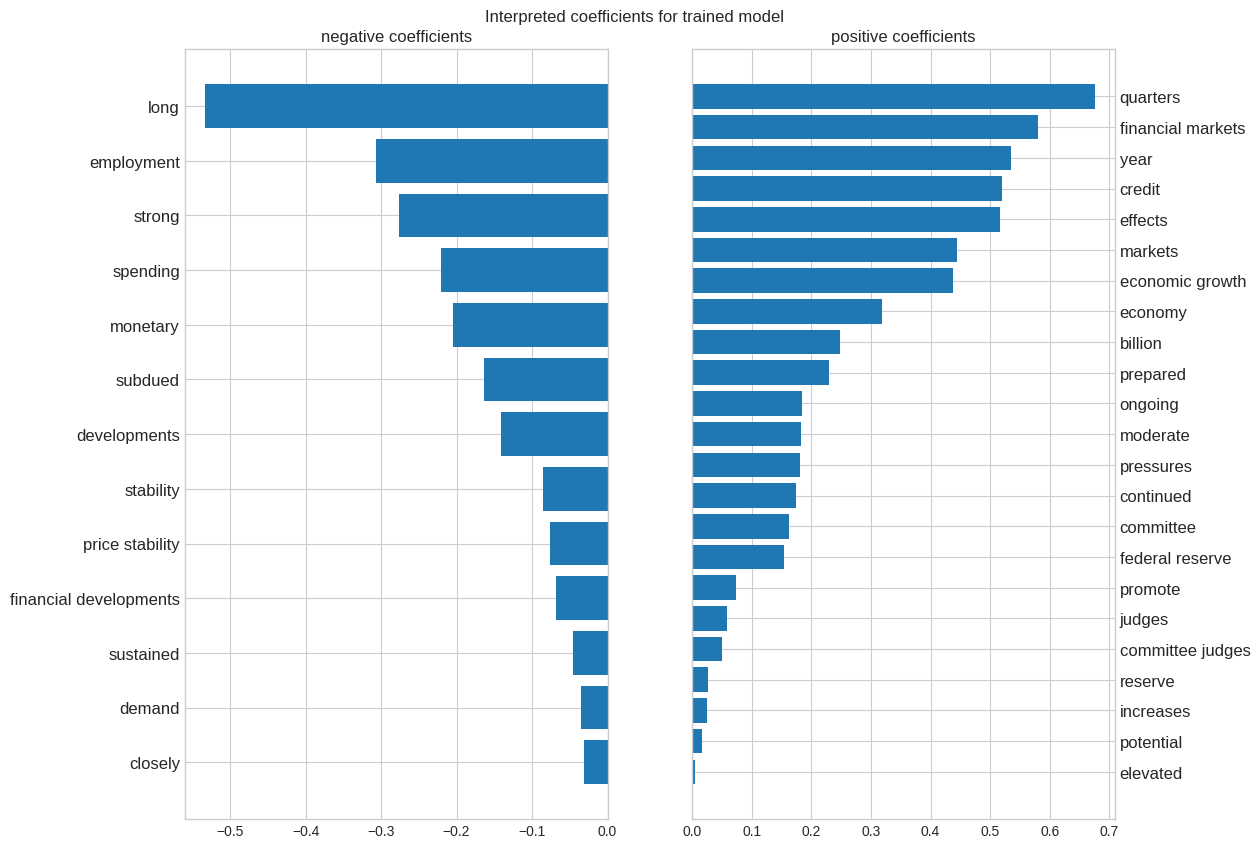

In [12]:
est = Pipeline([('tfidf', TfidfVectorizer(vocabulary=None,
                                          ngram_range=(1, 3),
                                          max_features=500,
                                          stop_words='english',
                                          token_pattern=r'\b[a-zA-Z]{3,}\b')),
                ('reg', ElasticNet(alpha=0.0075)),])
y = ret_fomc['Mkt-RF'].dropna()
X = statements['text']
idx_ = y.index.intersection(X.index)
X, y = X.loc[idx_], y.loc[idx_]
est.fit(X, y);
vocab_ = pd.Series(est.named_steps['tfidf'].vocabulary_).sort_values().index
interpret_coef = pd.DataFrame(np.transpose(est.named_steps['reg'].coef_), index=vocab_)
coefs_plot(interpret_coef, title='Interpreted coefficients for trained model')

In [13]:
lexica = {'positive': interpret_coef.squeeze().nlargest(n=10),
          'negative': interpret_coef.squeeze().nsmallest(n=10), }

In [14]:
idx_ = pd.Series(est.predict(X), index=X.index).sort_values().pipe(lambda x: [x.index[0], x.index[-1]])
show_text(statements.loc[idx_], lexica=lexica, n=None)

,last_update,text,voting,release_time,url
release_date,,,,,
2002-01-30,2002-01-30,"The Federal Open Market Committee decided today to keep its target for the federal funds rate unchanged at 1-3/4 percent. Signs that weakness in demand is abating and economic activity is beginning to firm have become more prevalent. With the forces restraining the economy starting to diminish, and with the long-term prospects for productivity growth remaining favorable and monetary policy accommodative, the outlook for economic recovery has become more promising. The degree of any strength in business capital and household spending, however, is still uncertain. Hence, the Committee continues to believe that, against the background of its long-run goals of price stability and sustainable economic growth and of the information currently available, the risks are weighted mainly toward conditions that may generate economic weakness in the foreseeable future.",,,https://www.federalreserve.gov/boarddocs/press/general/2002/20020130/
2007-09-18,2007-09-18,"The Federal Open Market Committee decided today to lower its target for the federal funds rate 50 basis points to 4-3/4 percent. Economic growth was moderate during the first half of the year, but the tightening of credit conditions has the potential to intensify the housing correction and to restrain economic growth more generally. Todayâs action is intended to help forestall some of the adverse effects on the broader economy that might otherwise arise from the disruptions in financial markets and to promote moderate growth over time. Readings on core inflation have improved modestly this year. However, the Committee judges that some inflation risks remain, and it will continue to monitor inflation developments carefully. Developments in financial markets since the Committeeâs last regular meeting have increased the uncertainty surrounding the economic outlook. The Committee will continue to assess the effects of these and other developments on economic prospects and will act as needed to foster price stability and sustainable economic growth.","Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Charles L. Evans; Thomas M. Hoenig; Donald L. Kohn; Randall S. Kroszner; Frederic S. Mishkin; William Poole; Eric Rosengren; and Kevin M. Warsh.",For immediate release,https://www.federalreserve.gov/newsevents/press/monetary/20070918a.htm
